<h1 style='background:#483D8B; border:0; border-radius:10px; font-weight:bold; color:white; text-align:center; padding:10px; margin:10px;'>IMPORTING THE RELEVANT LIBRARIES</h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(20, 15)})

import warnings
warnings.filterwarnings("ignore")

In [2]:
raw_data = pd.read_csv('input_data/hr_employee_churn_data.csv')
raw_data.head()

,empid,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,left
0,1,0.38,0.53,2,157,3,0,0,low,1
1,2,0.80,0.86,5,262,6,0,0,medium,1
2,3,0.11,0.88,7,272,4,0,0,medium,1
3,4,0.72,0.87,5,223,5,0,0,low,1
4,5,0.37,0.52,2,159,3,0,0,low,1


In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   empid                  14999 non-null  int64  
 1   satisfaction_level     14997 non-null  float64
 2   last_evaluation        14999 non-null  float64
 3   number_project         14999 non-null  int64  
 4   average_montly_hours   14999 non-null  int64  
 5   time_spend_company     14999 non-null  int64  
 6   Work_accident          14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   salary                 14999 non-null  object 
 9   left                   14999 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 1.1+ MB


<h1 style='background:#483D8B; border:0; border-radius:10px; font-weight:bold; color:white; text-align:center; padding:10px; margin:10px;'>FEATURE ENGINEERING</h1>

## **<span style="color:#483D8B;"><justify>Drop irrelevant features</justify></span>**

In [4]:
raw_data.drop(['empid'], axis=1, inplace=True)

## **<span style="color:#483D8B;"><justify>Deal with missing values</justify></span>**

In [5]:
raw_data.isnull().sum()

satisfaction_level       2
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
promotion_last_5years    0
salary                   0
left                     0
dtype: int64

In [6]:
raw_data.fillna(raw_data['satisfaction_level'].mean(), inplace=True)

In [7]:
raw_data.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
promotion_last_5years    0
salary                   0
left                     0
dtype: int64

## **<span style="color:#483D8B;"><justify>Handling Categorical Features</justify></span>**

In [8]:
raw_data = pd.get_dummies(raw_data, drop_first=True)
raw_data.head(3)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,left,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,0,1,1,0
1,0.80,0.86,5,262,6,0,0,1,0,1
2,0.11,0.88,7,272,4,0,0,1,0,1


<h1 style='background:#483D8B; border:0; border-radius:10px; font-weight:bold; color:white; text-align:center; padding:10px; margin:10px;'>MODEL BUILDING</h1>

In [9]:
features = raw_data.drop(['left'], axis=1)
target = raw_data['left']

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [11]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

model_param = {
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'param': {
            'n_estimators': [10, 50, 100, 130],
            'criterion': ['gini', 'entropy'],
            'max_depth': range(2, 4, 1),
            'max_features': ['auto', 'log']
        }
    },
    'XGBClassifier': {
        'model': XGBClassifier(),
        'param': {
            'learning_rate': [0.5, 0.1, 0.01, 0.001],
            'max_depth': [3, 5, 10, 20],
            'n_estimators': [10, 50, 100, 150]
        }
    }    
}

scores = []
for model_name, mp in model_param.items():
    model_selection = GridSearchCV(estimator=mp['model'], param_grid=mp['param'], cv=10, return_train_score=False)
    model_selection.fit(X=x_train, y=y_train)
    scores.append({
        'model': model_name,
        'best_score': model_selection.best_score_,
        'best_params': model_selection.best_params_
    })

In [12]:
scores

[{'model': 'RandomForestClassifier',
  'best_score': 0.9175774951348347,
  'best_params': {'criterion': 'entropy',
   'max_depth': 3,
   'max_features': 'auto',
   'n_estimators': 50}},
 {'model': 'XGBClassifier',
  'best_score': 0.9909159021406728,
  'best_params': {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 150}}]

In [13]:
model_xgb = XGBClassifier(learning_rate=0.1, max_depth=20, n_estimators=150)
model_xgb.fit(x_train, y_train)

XGBClassifier(max_depth=20, n_estimators=150)

In [14]:
model_xgb.score(x_test, y_test)

0.987

<AxesSubplot:>

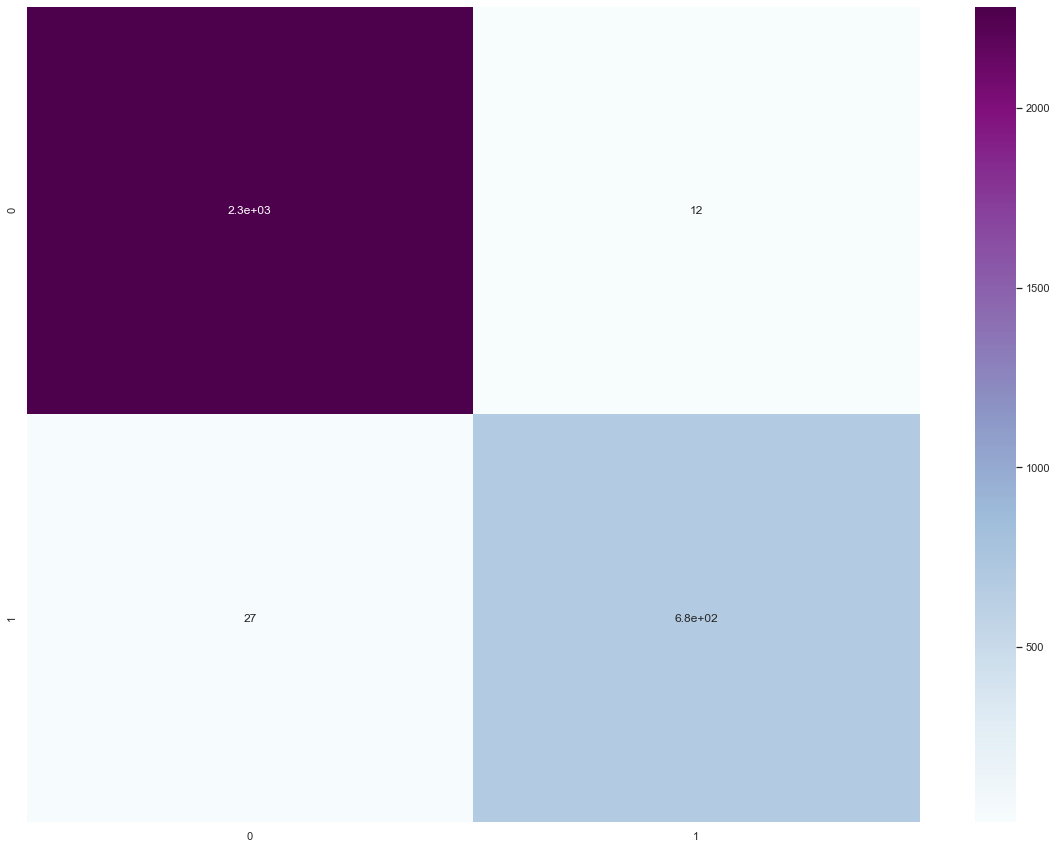

In [15]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, model_xgb.predict(x_test))
sns.heatmap(cm, annot=True, cmap='BuPu')

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_test, model_xgb.predict(x_test)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2294
           1       0.98      0.96      0.97       706

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000



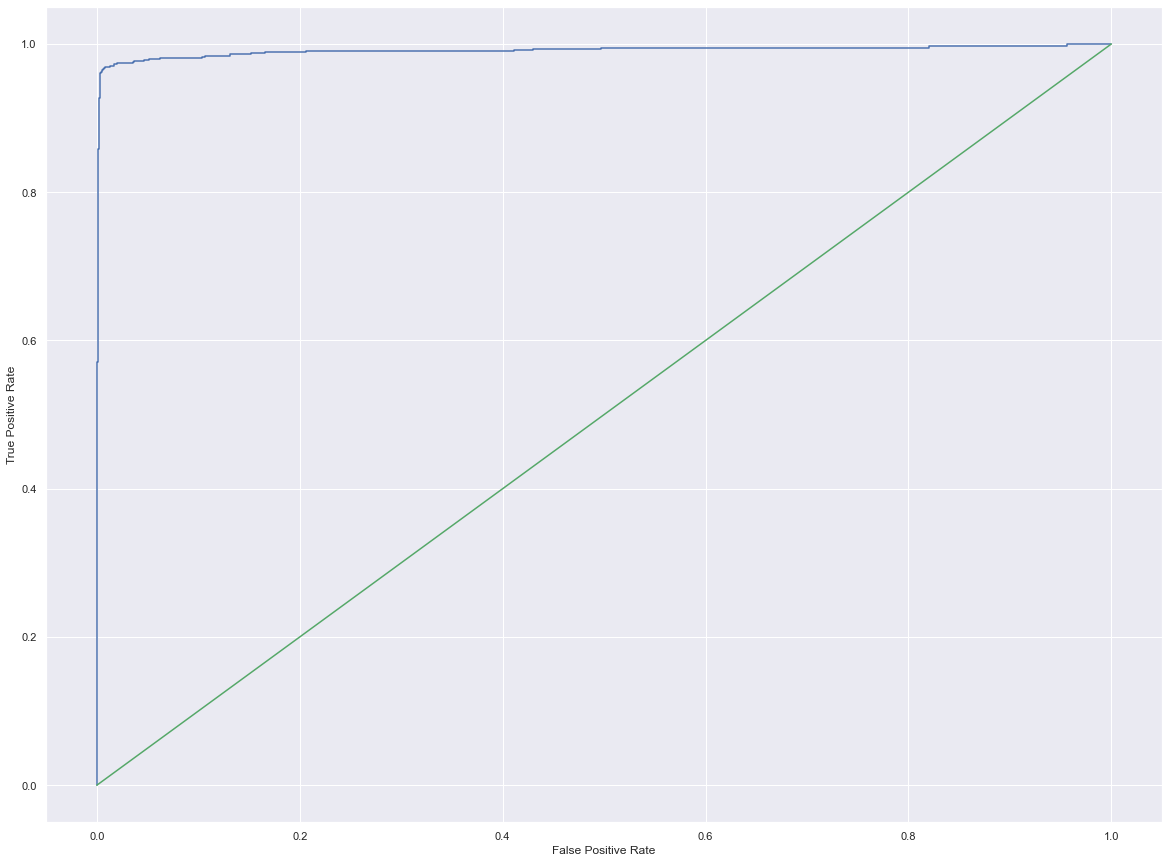

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

def plot_sklearn_roc_curve(y_real, y_pred):
    fpr, tpr, _ = roc_curve(y_real, y_preds)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    plt.plot([0, 1], [0, 1], color = 'g')

plot_sklearn_roc_curve(y_test, model_xgb.predict_proba(x_test)[:, 1])